In [0]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Get Data


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Mounted at /content/drive/


In [0]:
path = '/content/drive/My Drive/project/data_main/'

In [0]:
BASE_DATA_FOLDER = path
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train_images")

In [0]:
data_folder = path
train_df_path = path + 'train.csv' 

df = pd.read_csv(train_df_path)
# https://www.kaggle.com/amanooo/defect-detection-starter-u-net
df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
df['ClassId'] = df['ClassId'].astype(int)
df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
df['defects'] = df.count(axis=1)
df = df[df['defects'] >0] 
df2 = df.reset_index()

# Create Mask

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([0, 0, 10])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output 

In [0]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [0]:
def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')

# Get Images, Labels and Mask

In [0]:
tr = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head() 

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [15]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train["class"] = df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
df_train["image"] = df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[0])

print(len(df_train))
df_train.head()

7095


,ImageId_ClassId,EncodedPixels,class,image
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,0002cc93b.jpg
1,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...,3,0007a71bf.jpg
2,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1,000a4bcdd.jpg
3,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,4,000f6bf48.jpg
4,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...,3,0014fce06.jpg


In [0]:
images = []
labels = []

for image_name in os.listdir(TRAin_DATA_FOLDER):
  try:
    labels.append(list(df_train[df_train["image"] == image_name]["class"])[0])
    image = cv2.imread(os.path.join(TRAin_DATA_FOLDER, image_name), cv2.IMREAD_COLOR)
    image = cv2.resize(image, (150, 150))
    image = segment_plant(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (45,45))
    image = image.flatten() 
    images.append(image)
  except IndexError: 
    pass 
  
images = np.array(images)
labels = np.array(labels)

In [0]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [0]:
label_ids = np.array([label_to_id_dict[x] for x in labels])


# Plot

In [0]:
images_scaled = StandardScaler().fit_transform(images)


In [0]:
pca = PCA(n_components=180)
pca_result = pca.fit_transform(images_scaled)

In [0]:
tsne = TSNE(n_components=2, perplexity=40.0)


In [0]:
tsne_result = tsne.fit_transform(pca_result)


In [0]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)


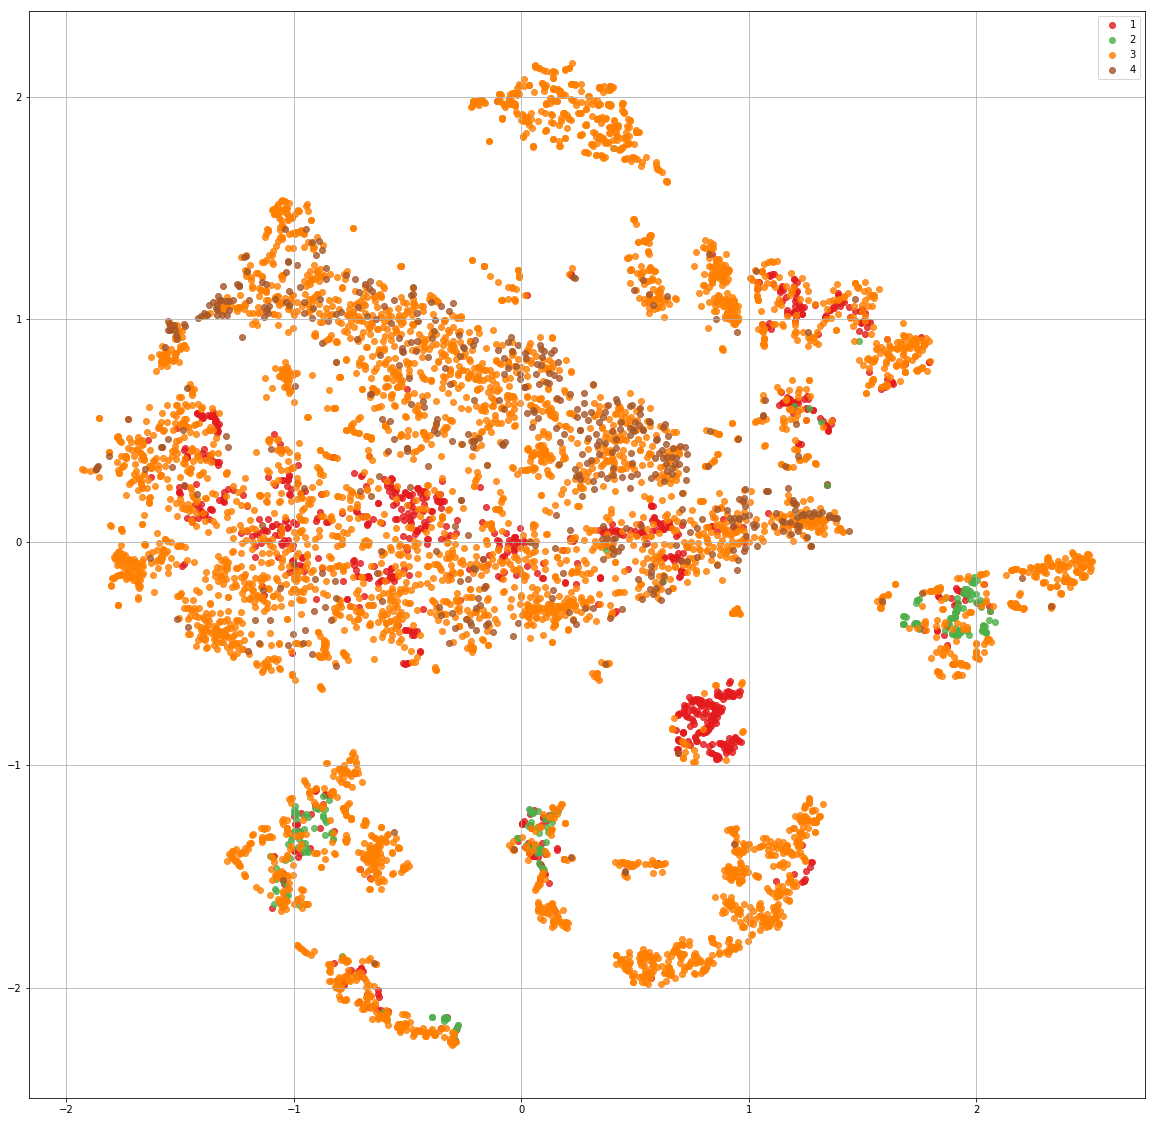

In [38]:
visualize_scatter(tsne_result_scaled, label_ids)
